In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint as pp
import csv
import datetime
from dateutil.parser import parse
from pandas.tools.plotting import scatter_matrix
from patsy import dmatrices
import statsmodels.formula.api as smf
from sklearn import cross_validation
from sklearn import datasets
from sklearn import svm
import seaborn as sns
import statsmodels.api as sm
import matplotlib as mpl
from numpy.random import randn
from scipy import stats

%matplotlib inline

sns.set_palette("deep", desat=.8)
sns.set_context(rc={"figure.figsize": (14, 8)})

In [3]:
complete_df = pd.read_csv("complete_post2010.csv")

In [4]:
complete_df = complete_df[np.isfinite(complete_df['comments_score'])]
complete_df = complete_df[np.isfinite(complete_df['posts_score'])]
complete_df = complete_df[np.isfinite(complete_df['foreign_gross'])]
complete_df = complete_df[np.isfinite(complete_df['opening_weekend'])]

complete_df["opening_weekend"] = complete_df["opening_weekend"].apply(lambda x: int(x))
complete_df["foreign_gross"] = complete_df["foreign_gross"].apply(lambda x: int(x))
# complete_df["release_date"] = complete_df["release_date"].apply(lambda x: parse(x).date())

complete_df = complete_df[complete_df['comments_score']>0]
complete_df = complete_df[complete_df['posts_score']>0]

complete_df["reddit_buzz"]=complete_df['comments_score']+complete_df["posts_score"]
complete_df["ow_rb"]=complete_df["opening_weekend"]*complete_df["reddit_buzz"]
complete_df = complete_df[complete_df['reddit_buzz']>0]
# complete_df["opening_weekend_adj"] = complete_df['opening_weekend']*3

In [5]:
complete_df.describe()

,opening_weekend,foreign_gross,posts_score,comments_score,reddit_buzz,ow_rb
count,5.740000e+02,5.740000e+02,574.000000,574.000000,574.000000,5.740000e+02
mean,2.250218e+07,1.103344e+08,5178.818815,31792.092334,36970.911150,1.303453e+12
std,2.728470e+07,1.585056e+08,6640.978680,49707.943219,55252.926279,4.180857e+12
min,4.712200e+04,6.300000e+02,1.000000,2.000000,3.000000,9.771890e+05
25%,6.901067e+06,1.515000e+07,413.000000,1666.750000,2029.000000,1.572516e+10
50%,1.442660e+07,4.876004e+07,2275.000000,8881.000000,11438.000000,9.804439e+10
75%,2.733144e+07,1.296817e+08,7537.000000,42386.250000,54474.500000,7.145146e+11
max,2.074387e+08,9.605000e+08,34121.000000,394250.000000,415019.000000,5.668968e+13


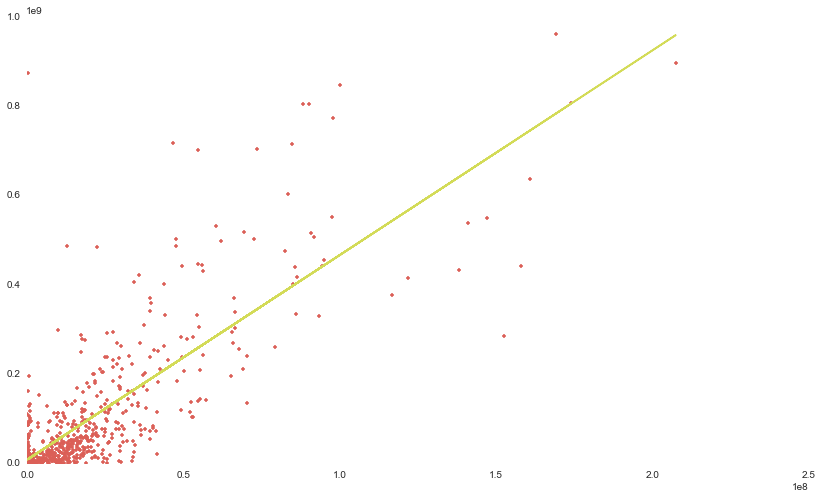

In [22]:
x=complete_df["opening_weekend"]
y=complete_df["foreign_gross"]
# y = np.log(y)
# x = np.log(x)
m, b = np.polyfit(x, y, 1)
plt.plot(x, y, '.')
plt.plot(x, m*x + b, '-')

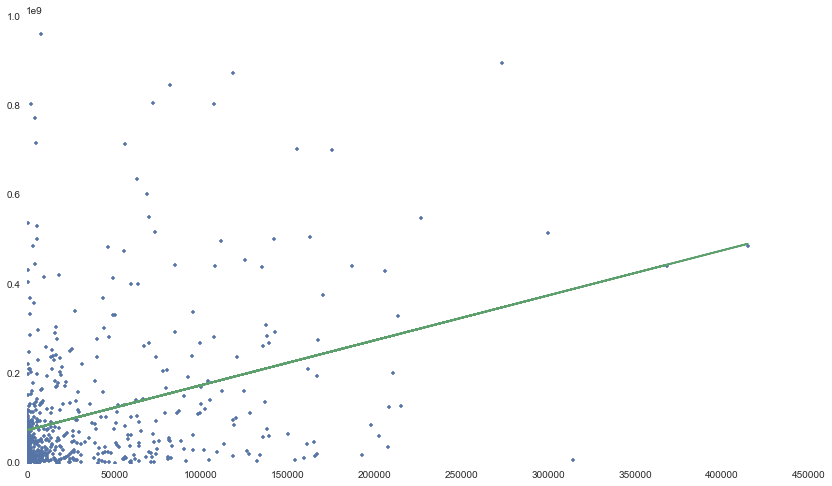

In [7]:
x=complete_df["reddit_buzz"]
y=complete_df["foreign_gross"]
m, b = np.polyfit(x, y, 1)
plt.plot(x, y, '.')
plt.plot(x, m*x + b, '-')

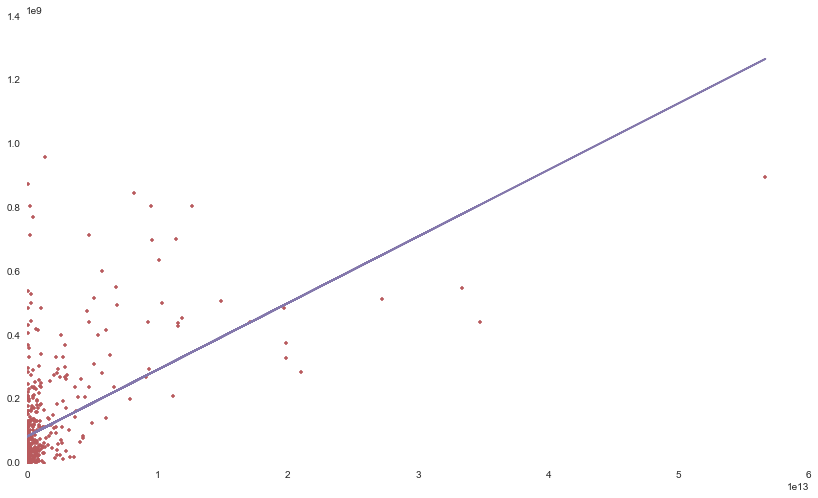

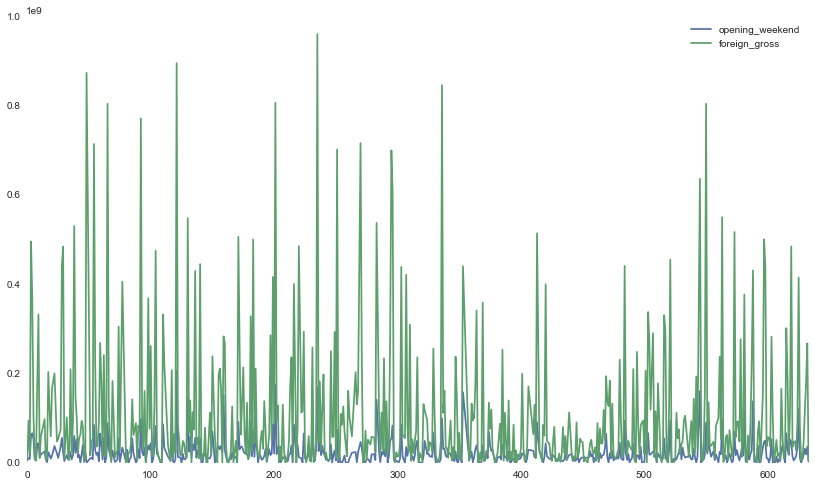

In [8]:
plt.hist(complete_df["foreign_gross"], histtype="stepfilled", alpha=.8)
plt.hist(complete_df["opening_weekend"], histtype="stepfilled", alpha=.8)


x=complete_df["ow_rb"]
y=complete_df["foreign_gross"]
m, b = np.polyfit(x, y, 1)
plt.plot(x, y, '.')
plt.plot(x, m*x + b, '-')



complete_df[["opening_weekend", "foreign_gross"]].plot()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x109d89310>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x10b8f24d0>]], dtype=object)

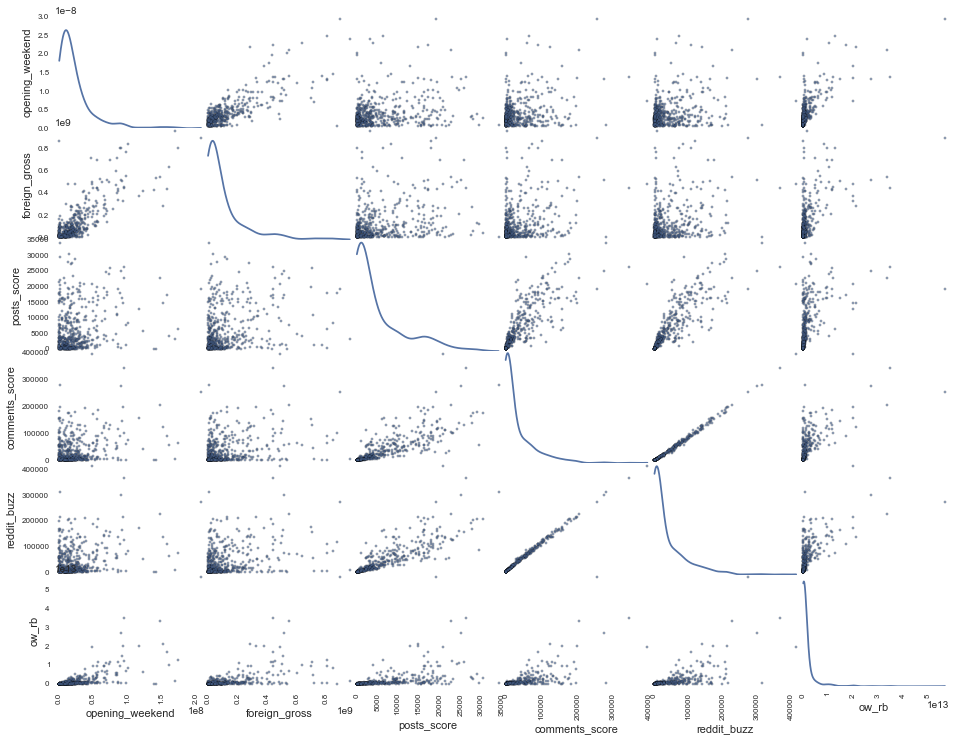

In [9]:
scatter_matrix(complete_df, alpha=0.6, figsize=(16,12), diagonal='kde')

In [74]:
model1 = smf.ols(formula="foreign_gross ~ opening_weekend", data=complete_df).fit()
model1.summary()
# model.mse_resid
msea1 = np.mean(np.abs(model1.resid))

60878596.162025422

In [75]:
model2 = smf.ols(formula="foreign_gross ~ opening_weekend + reddit_buzz", data=complete_df).fit()
model2.summary()
msea2 = np.mean(np.abs(model2.resid))
# model.mse_resid

59334463.563120447

In [76]:
model3 = smf.ols(formula="foreign_gross ~ opening_weekend + reddit_buzz + ow_rb", data=complete_df).fit()
model3.summary()
msea3 = np.mean(np.abs(model3.resid))
# model["foreign_gross"].mean()

59242738.855793476

In [13]:
msk = np.random.rand(len(complete_df)) < 0.5
train = complete_df[msk]
test = complete_df[~msk]

# train["reddit_buzz"]=train['comments_score']+train["posts_score"]
# test["reddit_buzz"]=test['comments_score']+test["posts_score"]
# train.head()
test.head()

,title,opening_weekend,foreign_gross,release_date,posts_score,comments_score,reddit_buzz,ow_rb
0,Dead Man Down,5345250,7179244,2013-03-08,3645,9991,13636,72887829000
1,Pompeii,10340823,94611883,2014-02-21,392,1977,2369,24497409687
4,Cars 2,66135507,368400000,2011-06-24,3038,40692,43730,2892105721110
5,Green Lantern,53174303,103250000,2011-06-17,6117,53690,59807,3180195539521
7,The Guilt Trip,5290629,4729511,2012-12-19,149,533,682,3608208978


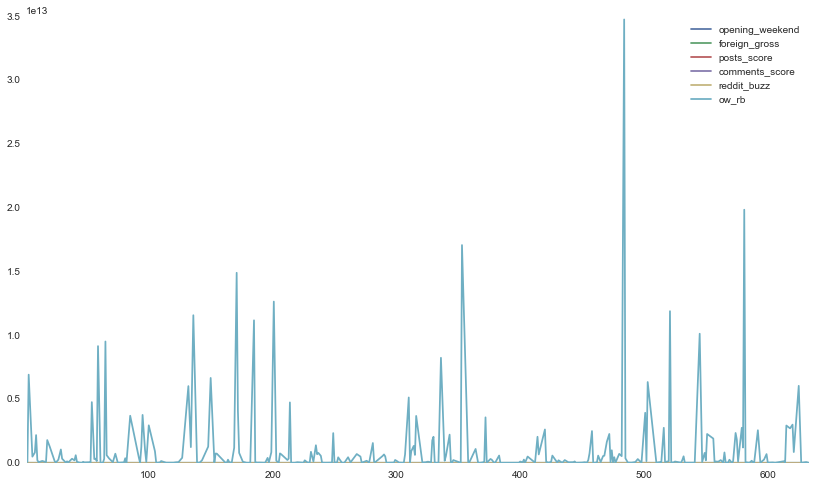

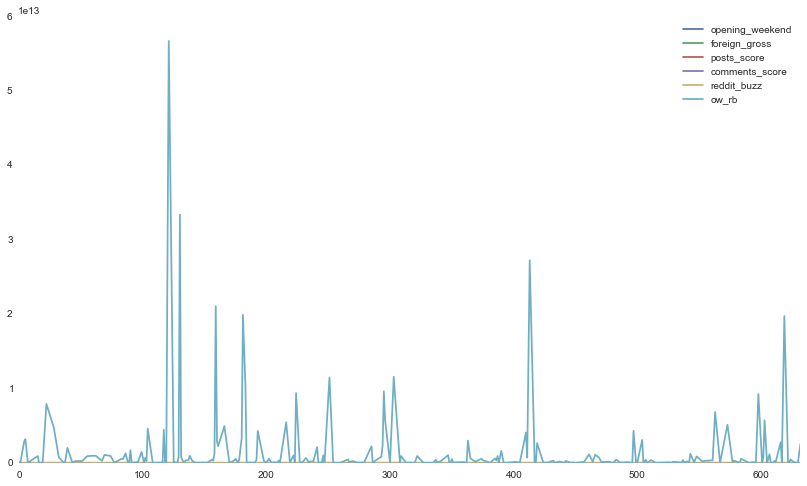

In [14]:
train.plot()
test.plot()

In [43]:
model = smf.ols(formula="foreign_gross ~ opening_weekend + reddit_buzz + ow_rb", data=train).fit()
model.summary()
model.mse_resid

10567470505040094.0

In [16]:
predictors =  ["opening_weekend", "reddit_buzz", "ow_rb"]
test_df = test[predictors]
test_df = sm.add_constant(test_df)
test_df.head()
y_pred = model.predict(test_df, transform=False)
y_pred[0:10]


array([  2.13188817e+07,   4.09893099e+07,   3.14607267e+08,
         2.56826582e+08,   1.57433122e+07,   7.28427672e+07,
        -1.39313278e+06,   3.58854060e+07,   2.19596545e+08,
         2.71580671e+08])

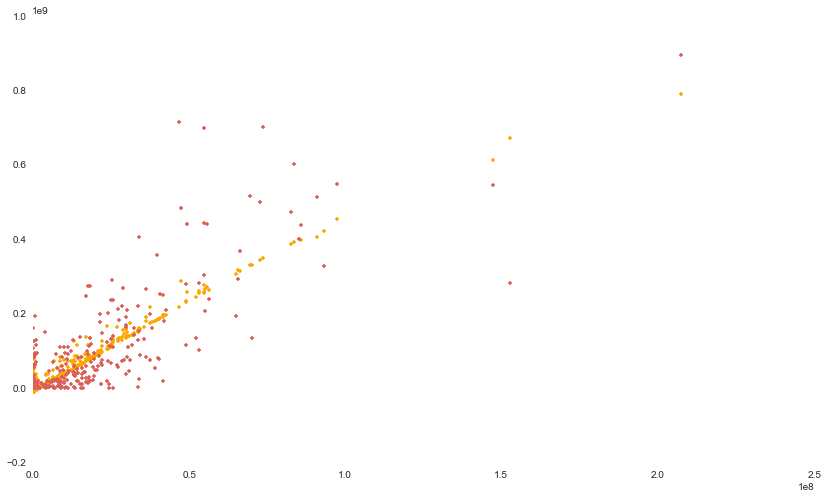

In [32]:
x=test_df["opening_weekend"]
y=y_pred
plt.plot(x, y, '.', color="orange")


x1=test["opening_weekend"]
y1=test["foreign_gross"]
plt.plot(x1, y1, '.')

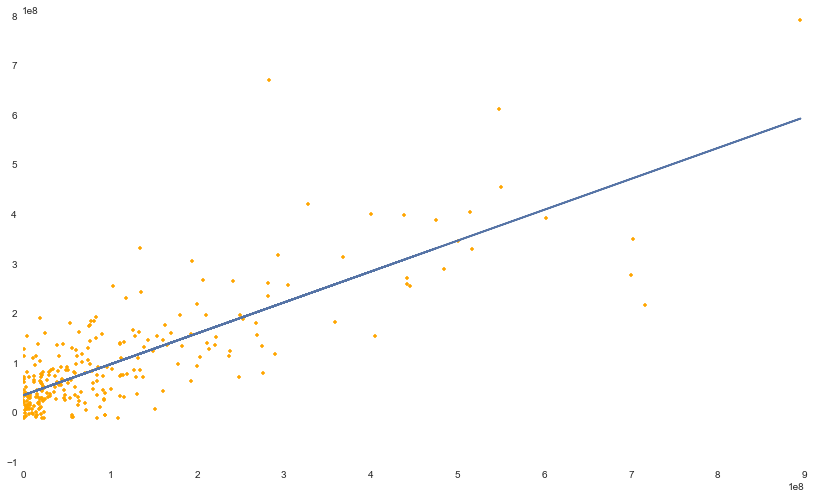

In [18]:
x=test["foreign_gross"]
y=y_pred
m, b = np.polyfit(x, y, 1)
plt.plot(x, y, '.', color="orange")
plt.plot(x, m*x + b, '-')

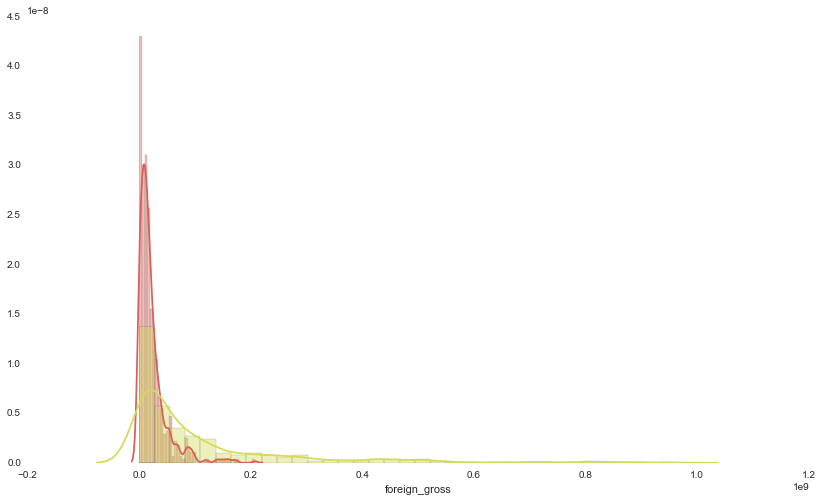

In [29]:
sns.set_palette("hls")
mpl.rc("figure", figsize=(14, 8))
data = complete_df["opening_weekend"]
data2 = complete_df["foreign_gross"]
data3 = complete_df["reddit_buzz"]*400
sns.distplot(data);
sns.distplot(data2);
# sns.distplot(data3);

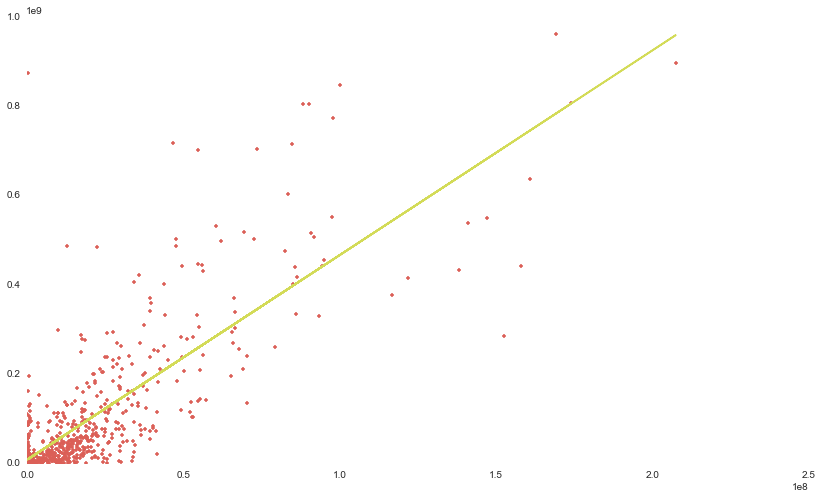

In [44]:
x=complete_df["opening_weekend"]
y=complete_df["foreign_gross"]
m, b = np.polyfit(x, y, 1)
plt.plot(x, y, '.')
plt.plot(x, m*x + b, '-')

In [ ]:
# Mean squared of residuals of model one and comparing mean square of residuals to model two
